The newsvendor is a mathematical model used to determine the optimal order quantity for a situation with fixed unit costs and uncertain demand for a perishable product. If the order quantity is $q$, each unit of demand above $q$ is a lost sale. The standard newsvendor profit function is $\mathbb{E}[Profit] =\mathbb{E}\left[p\min(q,D)\right]-cq$, where:
- $D$ is a random variable with probability distribution $F$ representing demand,
- each unit is sold for price $p$,
- each unit is purchased for price $c$,
- $q$ is the number of units stocked, and
- $\mathbb{E}$ is the expectation operator.

It can be shown that the order quantity that maximizes expected profit is:

$$q^{*}=F^{-1}\left(\frac{p-c}{p}\right),$$ 
where $F^{-1}$ denotes the inverse cumulative distribution function of $D$.

In [1]:
import gurobipy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm

import optutilities

We will use a sample average approximation to (approximately) solve the newsvendor problem using Gurobi. The specific formulation we will use follows.

<u>Set(s)</u></br>
$S$ - scenarios, $s\in\{1, \ldots, n\}$

<u>Parameters</u></br>
$c$ - unit cost</br>
$p$ - revenue</br>
$d_{s}$ - demand in scenario $s$

<u>Decision Variables</u></br>
$q$ - order quantity</br>
$X_{s}$ - sales in scenario $s$


\begin{align}
max \frac{1}{|S|}\left(\sum_{s\in S}pX_{s}\right) - cq\\
subject~to\qquad\qquad\qquad\qquad\qquad\\
X_{s} \leq d_{s}, \forall s \in S.\\
X_{s} \leq q, \forall s \in S.\\
X_{s} \geq 0, \forall s \in S.\\ 
q \geq 0.\\
\end{align}

The following code block randomly generates an array that we will assume represents a distribution for the historical sales of similar products.

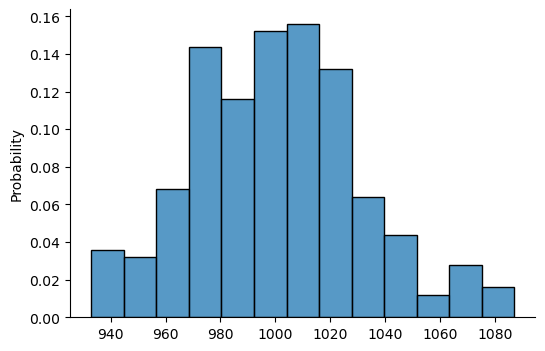

In [2]:
np.random.seed(0)

historical_sales = np.random.poisson(
    1000,
    size=250,
)

optutilities.distribution_fitting.plot_histogram_for_single_array(
    historical_sales,
)

The following code block calls a function that uses `scipy` to fit a parametric distribution to the data.

In [3]:
best_distribution = optutilities.distribution_fitting.get_best_parametric_distribution(historical_sales)

  0%|          | 0/8 [00:00<?, ?it/s]

best_fit_name = 'beta'


The following code block plots the historical data and a random sample from the fit distribution.

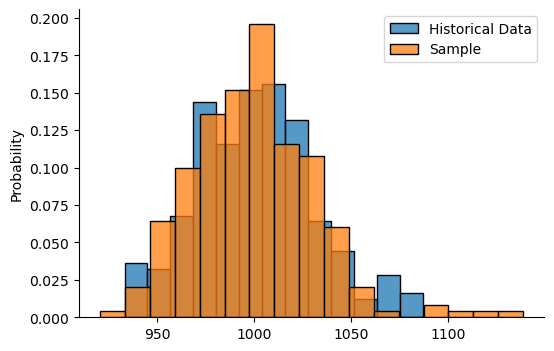

In [4]:
optutilities.distribution_fitting.plot_histogram_for_two_arrays(
    array1=historical_sales,
    array2=best_distribution.rvs(len(historical_sales)),
    array1_label='Historical Data',
    array2_label='Sample',
)

The following code block shows how we can use the `scipy` distribution object to compute the value of the Cumulative Distribution Function (CDF) for a range of possible values of the random variable represented by the distribution.

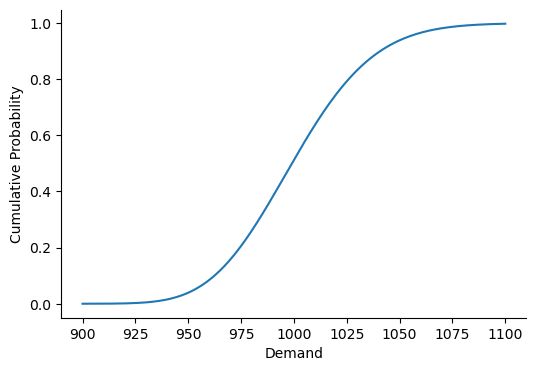

In [5]:
demand_values = np.arange(900, 1101, 1)
cdf_percentiles = best_distribution.cdf(demand_values)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

sns.lineplot(
    x=demand_values,
    y=cdf_percentiles,
)
ax.spines[['right', 'top']].set_visible(False)
ax.set_xlabel('Demand')
ax.set_ylabel('Cumulative Probability')

plt.show()

The mathematical method for computing the optimal newsvendor order quantity relies on the inverse of the CDF. The following code block shows how we can use the `scipy` distribution object to compute these values for a range of target probabilities.

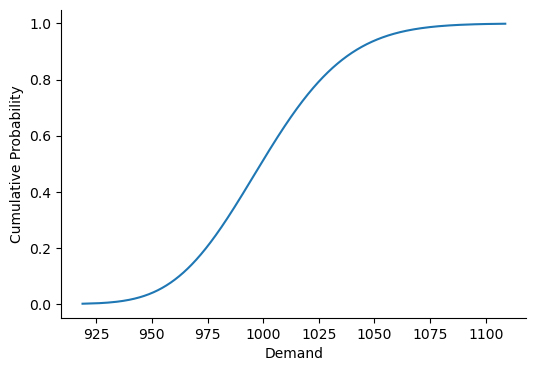

In [6]:
cdf_percentiles = np.arange(0.001, 1.000, 0.001)
demand_values = best_distribution.ppf(cdf_percentiles)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

sns.lineplot(
    x=demand_values,
    y=cdf_percentiles,
)
ax.spines[['right', 'top']].set_visible(False)
ax.set_xlabel('Demand')
ax.set_ylabel('Cumulative Probability')

plt.show()

The following code block defines the parameters we will need to solve the newsvendor instance and computes the optimal order quantity using the mathematical equation given at the beginning of the notebook. 

In [7]:
p = 10
c = 5
n = 100
scenarios = [i for i in range(1, n+1)]

d = {}
for scenario, demand_value in zip(scenarios, best_distribution.rvs(n)):
    d[scenario] = demand_value

optimal_order_quantity = best_distribution.ppf((p-c)/p)
print(f' - {optimal_order_quantity:,.2f}')

 - 999.04


The Gurobi model is constructed and solved in the following code block.

In [8]:
model = gurobipy.Model()

q = model.addVar(name='q')
X = model.addVars(
    scenarios,
    name='X',
)

unit_costs = c*q
expected_revenue = gurobipy.LinExpr()
for s in scenarios:
    expected_revenue.add(p*X[s])
expected_revenue = expected_revenue/len(scenarios)

expected_profit = expected_revenue - unit_costs

model.setObjective(
    expected_profit,
    sense=gurobipy.GRB.MAXIMIZE,
)

for s in scenarios:
    model.addConstr(X[s] <= d[s])

for s in scenarios:
    model.addConstr(X[s] <= q)

model.optimize()

gurobi_order_quantity = q.X
gurobi_expected_profit = expected_profit.getValue()

print('\n')
print(f' - Gurobi order quantity: {gurobi_order_quantity:,.2f}')
print(f' - Gurobi expected profit: {gurobi_expected_profit:,.2f}')

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-30
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 7 5800X 8-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 200 rows, 101 columns and 300 nonzeros
Model fingerprint: 0x1a2c2800
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-01, 5e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e+02, 1e+03]
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 100 rows, 101 columns, 200 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.0413175e+03   5.475931e+02   0.000000e+00      0s
      56    4.8774244e+03   0.000000e+00   0.000000e+00      0s

Solved in 56 iterations and 0.00 seconds (0.00 work units)
Optimal objective  4.877424392e+03


 - Gurobi order quan

The following code defines a loop that we will use to visualize how the order quantity selected by Gurobi varies as we increase the number of scenarios.

In [9]:
p = 10
c = 5

optimal_order_quantity = best_distribution.ppf((p-c)/p)

solution_dict = {}
for n in tqdm(range(1, len(historical_sales) + 1)):
    scenarios = [i for i in range(1, n+1)]
    
    d = {}
    for scenario, demand_value in zip(scenarios, best_distribution.rvs(n)):
        d[scenario] = demand_value
    
    model = gurobipy.Model()
    model.setParam('OutputFlag', 0)
    
    q = model.addVar(name='q')
    X = model.addVars(
        scenarios,
        name='X',
    )
    
    unit_costs = c*q
    expected_revenue = gurobipy.LinExpr()
    for s in scenarios:
        expected_revenue.add(p*X[s])
    expected_revenue = expected_revenue/len(scenarios)
    
    expected_profit = expected_revenue - unit_costs
    
    model.setObjective(
        expected_profit,
        sense=gurobipy.GRB.MAXIMIZE,
    )
    
    for s in scenarios:
        model.addConstr(X[s] <= d[s])
    
    for s in scenarios:
        model.addConstr(X[s] <= q)
    
    model.optimize()
    
    gurobi_order_quantity = q.X
    gurobi_expected_profit = expected_profit.getValue()

    solution_dict[n] = gurobi_order_quantity

  0%|          | 0/250 [00:00<?, ?it/s]

The visualization follows and shows how the order quantity selected by Gurobi converges towards the true optimal value as the number of scenarios increases.

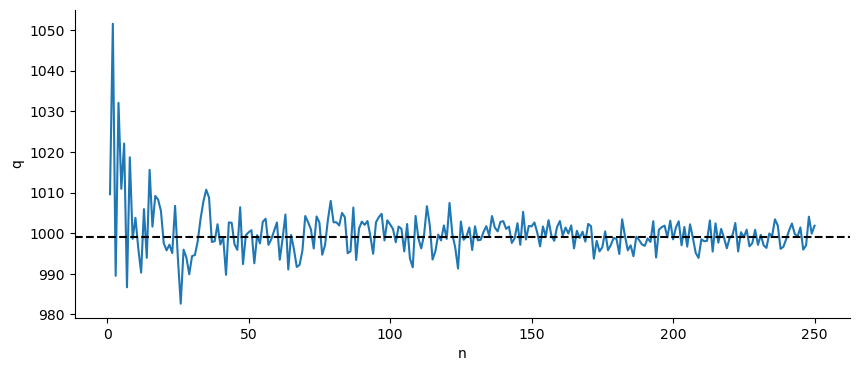

In [10]:
solution_df = pd.DataFrame.from_dict(
    solution_dict,
    orient='index',
).reset_index()

solution_df.columns = ['n', 'q']

fig, ax = plt.subplots(1, 1, figsize=(10, 4))

sns.lineplot(
    x=solution_df['n'],
    y=solution_df['q'],
    ax=ax,
)
ax.axhline(
    optimal_order_quantity,
    color='k',
    linestyle='--',
)
ax.spines[['right', 'top']].set_visible(False)

plt.show()